In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models


def norm1_diff(X, Y):
    return np.sum(np.abs(X - Y))


def norm2_diff(X, Y):
    return np.sqrt(np.sum(np.square(X - Y)))


model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")

# Layer Quantization

In [29]:
# get sample conv2 weight parameters
for name, parameter in model.named_parameters():
    layner_nm = ".".join(name.split(".")[:1])
    if "layer" in layner_nm:
        layer = getattr(model, layner_nm)
        conv2 = layer[0].conv2.weight
        conv2 = conv2.cpu().detach().numpy()
        break

print("Shape of conv2: ", conv2.shape)
print("Number of unique parameter in conv2: ", len(np.unique(conv2)))

Shape of conv2:  (64, 64, 3, 3)
Number of unique parameter in conv2:  36852


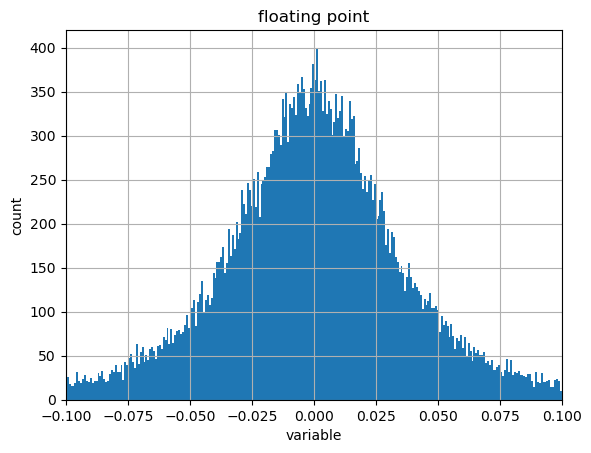

In [34]:
plt.hist(conv2.flatten(), bins=1000)
plt.xlabel("variable")
plt.ylabel("count")
plt.title("floating point")
plt.xlim([-0.1, 0.1])
plt.grid()

## Per-tensor quantization

### Asymmetric Quanziation

In [64]:
n_bit = 8
qrange = 2**n_bit

threshold = np.max(conv2) - np.min(conv2)
step = threshold / qrange  # scaling factor

print(
    f"""
    qrange: {qrange}
    threshold: {threshold}
    scaling factor: {step}
    """
)

# quantize with 8 bit
print("before quantization: ", conv2[0][0][0])
q_data = np.round(conv2 / step)
print("after quantization: ", q_data[0][0][0])

# dequantize q_data to be a fixed point number
deq_data = q_data * step
print("dequantization: ", deq_data[0][0][0])

# compare number of unique values count
print(len(np.unique(conv2)), len(np.unique(deq_data)))

# get norm 1 & norm 2 difference
print("loss: ", norm1_diff(conv2, deq_data), norm2_diff(conv2, deq_data))


    qrange: 256
    threshold: 0.7734677791595459
    scaling factor: 0.003021358512341976
    
before quantization:  [ 0.02594677 -0.10457563 -0.00477124]
after quantization:  [  9. -35.  -2.]
dequantization:  [ 0.02719223 -0.10574755 -0.00604272]
36852 183
loss:  27.903473 0.16780086


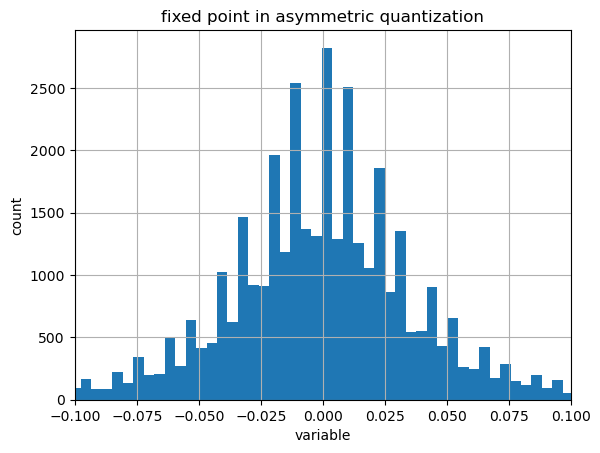

In [65]:
plt.hist(deq_data.flatten(), bins=len(np.unique(deq_data)))
plt.xlabel("variable")
plt.ylabel("count")
plt.title("fixed point in asymmetric quantization")
plt.xlim([-0.1, 0.1])
plt.grid()

### Symmetric Quantization

In [69]:
bit_width = 8

# maximum value that can be represented by the given bit-width
quant_max = 2 ** (bit_width - 1) - 1

# absolute maximum value of the data
max_value = np.max(np.abs(conv2))
scale = quant_max / max_value  # scaling factor

print(
    f"""
    bit_width: {bit_width}
    quant_max: {quant_max}
    scaling factor: {scale}
    """
)

# quantize with 8 bit
print("before quantization: ", conv2[0][0][0])
q_data = np.round(conv2 * scale).astype(np.int8)
print("after quantization: ", q_data[0][0][0])

# dequantize q_data to be a fixed point number
deq_data = q_data / scale
print("dequantization: ", deq_data[0][0][0])

# compare number of unique values count
print(len(np.unique(conv2)), len(np.unique(deq_data)))

# get norm 1 & norm 2 difference
print("loss: ", norm1_diff(conv2, deq_data), norm2_diff(conv2, deq_data))


    bit_width: 8
    quant_max: 127
    scaling factor: 260.29182257110665
    
before quantization:  [ 0.02594677 -0.10457563 -0.00477124]
after quantization:  [  7 -27  -1]
dequantization:  [ 0.02689289 -0.10372973 -0.00384184]
36852 150
loss:  35.22977532799585 0.21212740276953548


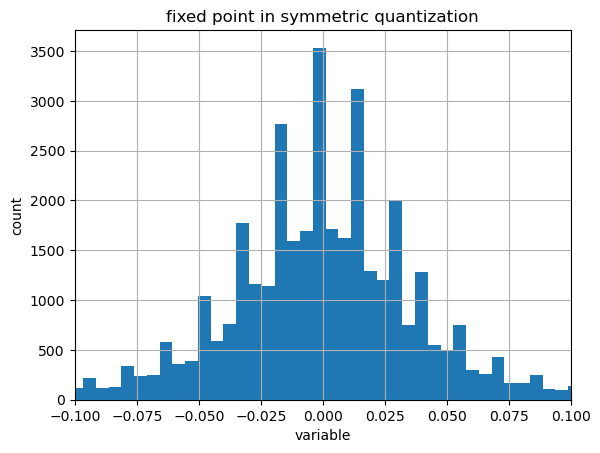

In [67]:
plt.hist(deq_data.flatten(), bins=len(np.unique(deq_data)))
plt.xlabel("variable")
plt.ylabel("count")
plt.title("fixed point in symmetric quantization")
plt.xlim([-0.1, 0.1])
plt.grid()

## Per-channel Quantization

In [80]:
n_bit = 8
qrange = 2 ** (n_bit - 1)

data_q = conv2.copy()
data_qn = conv2.copy()

print("Number of channel in conv2 layer: ", len(conv2))
for i in range(len(conv2)):
    threshold = np.max(np.abs(conv2[i, :]))
    step = threshold / qrange
    scale = qrange / threshold

    # quantization
    data_q[i, :] = np.round(conv2[i, :] / step)

    # dequantization
    data_qn[i, :] = data_q[i, :] / scale

print("Number of unique data after quantization: ", len(np.unique(data_q)))

Number of channel in conv2 layer:  64
Number of unique data after quantization:  250


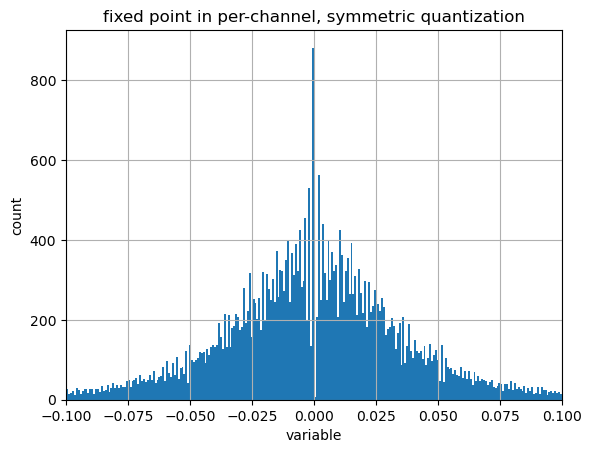

In [81]:
plt.hist(data_qn.flatten(), bins=1000)
plt.xlabel("variable")
plt.ylabel("count")
plt.title("fixed point in per-channel, symmetric quantization")
plt.xlim([-0.1, 0.1])
plt.grid()

### Weight-only quantization

In [104]:
def quantize(weight: np.array, bit_width: int = 8):
    # maximum value that can be represented by the given bit-width
    quant_max = 2 ** (bit_width - 1) - 1

    # absolute maximum value of the data
    max_value = np.max(np.abs(weight))
    scale = quant_max / max_value  # scaling factor

    # quantize with 8 bit
    q_data = np.round(weight * scale).astype(np.int8)

    # dequantize q_data to be a fixed point number
    deq_data = q_data / scale

    return deq_data


whitelist = [nn.Linear, nn.Conv2d, nn.BatchNorm2d]
to_quan_layers = []
for name, module in model.named_modules():
    if type(module) in whitelist:
        weight = module.weight.cpu().detach().numpy()
        deq_weight = quantize(weight, bit_width=8)
        module.weight.data = torch.from_numpy(deq_weight)
        to_quan_layers += [module]